# Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ for DESIJ1205+4110

**Author(s)**: Sulyman Hossain, S M Rafee Adnan, Anowar Shajib

## Import Libraries

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

## Load Data

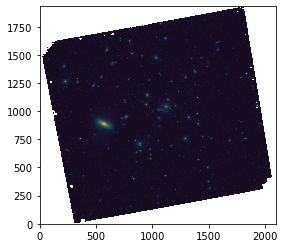

In [52]:
data, header = fits.getdata("DESIJ1205+4110_F140W_drz_sci.fits", header=True)
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

/tmp/ipykernel_26695/3998831433.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


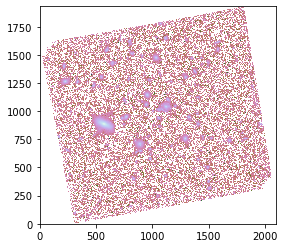

In [53]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture Photometry and Plotting

/tmp/ipykernel_26695/511389273.py:25: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


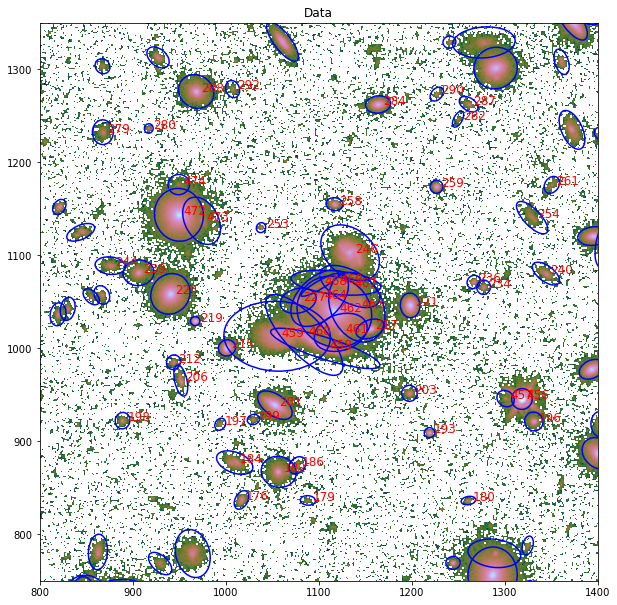

In [65]:
# Background subtraction
bkg_subtracted_data = data - bkg.background

# Source detection and segmentation
threshold = 5 * bkg.background_rms
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

# Source catalog creation
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)

# Plotting
norm = simple_norm(data, "sqrt")
fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

# Plot Kron apertures and label nearby sources
cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[462]) < 250
        and np.abs(cat.ycentroid[i] - cat.ycentroid[462]) < 250
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

# Set axis limits
set_x_lim1, set_x_lim2 = 800, 1400
set_y_lim1, set_y_lim2 = 750, 1350

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# Hide text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

# Show the plot
plt.show()

## Identify the central deflector's ID

/tmp/ipykernel_26695/82136839.py:9: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2)


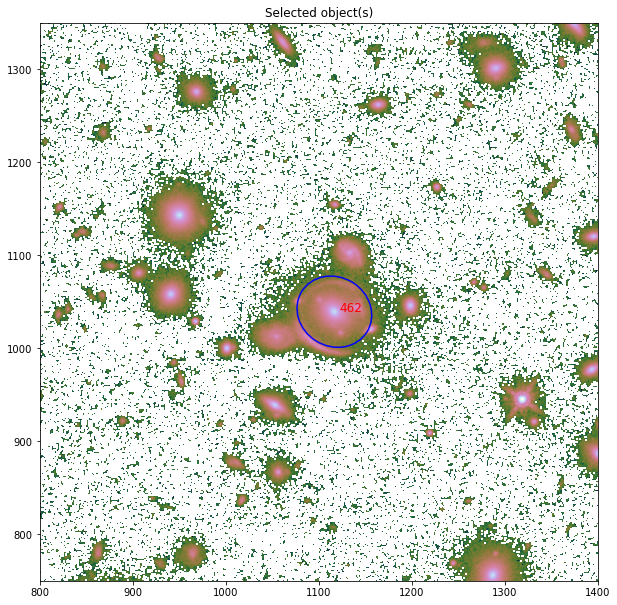

In [55]:
# Defining a function for labeling only selected objects


def label_selected_objects(selected_ids):
    # Background subtraction
    data - bkg.background

    # Plotting
    simple_norm(data, "sqrt")
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
    ax1.imshow(
        np.log10(data - bkg.background),
        origin="lower",
        cmap="cubehelix",
        vmin=-4,
        vmax=2,
    )
    ax1.set_title("Selected object(s)")

    # Plot Kron apertures and label selected objects
    for obj_id in selected_ids:
        labels = [obj_id + 1]
        cat_subset = cat.get_labels(labels)
        cat_subset.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

        ax1.text(
            cat.xcentroid[obj_id] + 5,
            cat.ycentroid[obj_id],
            f"{obj_id}",
            c="r",
            fontsize=12
            # transform=ax1.transAxes
        )

    # Set axis limits
    ax1.set_xlim(set_x_lim1, set_x_lim2)
    ax1.set_ylim(set_y_lim1, set_y_lim2)

    # Hide text outside of the axes
    ax1.set_clip_on(True)
    ax1.set_clip_box(ax1.bbox)

    # Show the plot
    plt.show()


# Guessing the lens galaxy
id_central = [462]

# Calling the function label id_central
label_selected_objects(id_central)

## Creating A List of Neighboring Galaxies

In [56]:
# optional format
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08:
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 20 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 20 arcsecond radius: 47


In [57]:
# Close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 20 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 20 arcsecond radius: 34


## Pixels to Arcsec unit

In [58]:
def distance_arcsec(pixel_distance):
    """Convert distance from unit of pixels into arcsec unit.

    :param pixel_distance: distance in unit of pixels

    :return: distance in arcsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

## Identify the unwanted objects

/tmp/ipykernel_26695/82136839.py:9: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2)


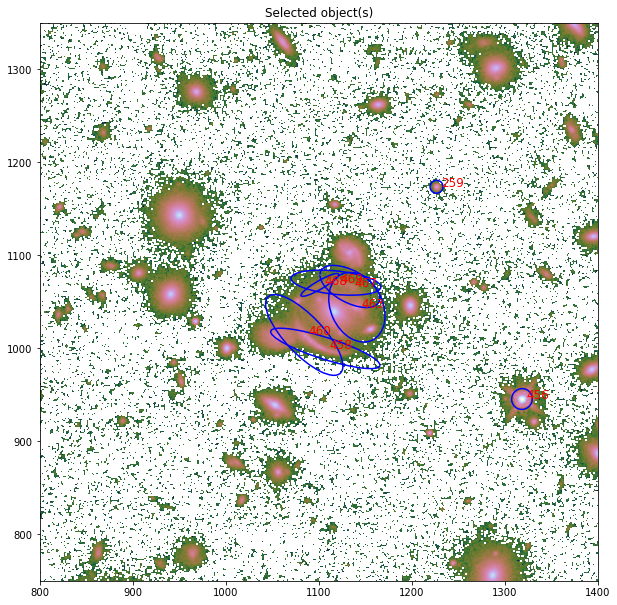

In [59]:
selected_object_ids = [463, 469, 467, 468, 458, 460, 259, 456]
label_selected_objects(selected_object_ids)

## Removing the unwanted objects from the neighboring galaxy list

In [60]:
# All close galaxies

remove_list = [
    462,  # lens galaxy
    463,
    469,
    467,
    468,
    458,
    460,  # ARC objects
    # Probable Stars
]
df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

         Distance(pixels)      Distance(arcsec)        Flux  Axis Ratio
464  [21.363922244686123]  [1.7091137795748725]  235.920443    0.614467
461   [23.25237834355944]  [1.8601902674847364]  141.526328    0.661717
227   [40.63835048304303]  [3.2510680386434094]   70.703469    0.666984
217  [42.690653006573044]  [3.4152522405258092]   93.135690    0.609441
246    [65.6272839825272]   [5.250182718602123]  317.216603    0.697718
459   [66.91907803802889]   [5.353526243042257]  376.934208    0.656407
221   [81.76423543661251]   [6.541138834928935]  201.315648    0.792928
258  [115.64162804545923]   [9.251330243636646]   23.498824    0.745520
201  [119.13181564367467]   [9.530545251493878]  325.244725    0.537086
203  [119.24871431361979]   [9.539897145089487]   12.017500    0.967404
253  [119.97632027769643]   [9.598105622215618]    2.590624    0.892507
215  [121.90007754936441]   [9.752006203949055]  134.832992    0.919106
199  [144.99968888189682]  [11.599975110551629]    3.873261    0

In [61]:
# Excluding galaxies lower than 1% of the central deflector

remove_list_1 = [
    462,  # Lens galaxy
    463,
    469,
    467,
    468,
    458,
    460,  # ARC objects
    259,
    456,  # Probable Stars
]

df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})
df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratioe"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

         Distance(pixels)      Distance(arcsec)        Flux  Axis Ratioe
464  [21.363922244686123]  [1.7091137795748725]  235.920443     0.614467
461   [23.25237834355944]  [1.8601902674847364]  141.526328     0.661717
227   [40.63835048304303]  [3.2510680386434094]   70.703469     0.666984
217  [42.690653006573044]  [3.4152522405258092]   93.135690     0.609441
246    [65.6272839825272]   [5.250182718602123]  317.216603     0.697718
459   [66.91907803802889]   [5.353526243042257]  376.934208     0.656407
221   [81.76423543661251]   [6.541138834928935]  201.315648     0.792928
258  [115.64162804545923]   [9.251330243636646]   23.498824     0.745520
201  [119.13181564367467]   [9.530545251493878]  325.244725     0.537086
215  [121.90007754936441]   [9.752006203949055]  134.832992     0.919106
219  [149.97096708422657]  [11.997677366738005]   52.411847     0.954327
193  [165.48636668965383]  [13.238909335172174]   20.365859     0.951687
473   [173.0059482362782]  [13.840475858902115]   5

## Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ and the corresponding radii

/tmp/ipykernel_26695/1232697193.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_26695/1232697193.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_26695/1232697193.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_26695/1232697193.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2



EXCLUDING DIM SOURCES
R 10: [9.7520062]
R 20: [18.05846883]
Sigma 10: [0.0334705]
Sigma 20: [0.01952173]

FOR All SOURCES
R 10: [9.53989715]
R 20: [13.84047586]
Sigma 10: [0.0349754]
Sigma 20: [0.03323365]


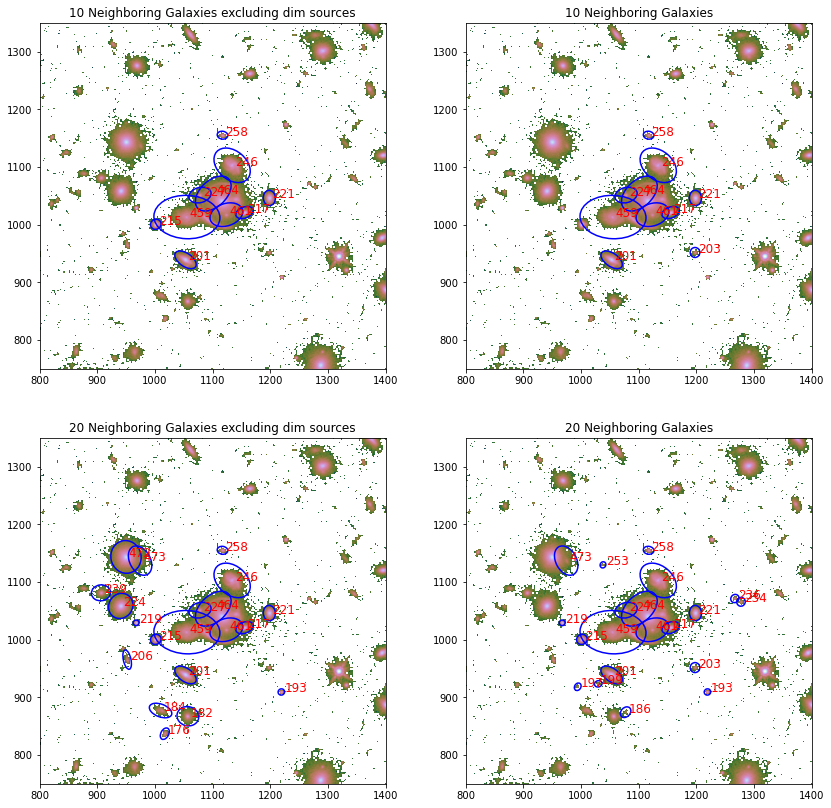

In [62]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighboring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighboring Galaxies")
axs[1, 0].set_title("20 Neighboring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighboring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(arcsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(arcsec)")]
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)

## Store the results to the YAML file

In [63]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1205+4110_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20_flux_selected": Sigma_20_1,
    "Sigma_10": Sigma_10_all,
    "Sigma_20": Sigma_20_all,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [64]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.890063589750755, 'Sigma_10': 0.03497540423098416, 'Sigma_10_flux_selected': 0.033470499182065745, 'Sigma_20': 0.03323365282195216, 'Sigma_20_flux_selected': 0.019521728807469423, 'center_x_light': [-0.326233380973289, 0.0004705468933001167, 0.0004928520532527236], 'center_x_mass': [-0.11356115468864908, 0.013204509405366854, 0.014294255682272133], 'center_y_light': [-0.06419256050984971, 0.0006157156276721532, 0.0005367634846871194], 'center_y_mass': [-0.12218458749668629, 0.01368130584080357, 0.014509661982000738], 'gamma': [2.0458939895364825, 0.026555650068348147, 0.021597652473030582], 'gamma_shear': [0.09598558476940806, 0.004603918770756957, 0.005170220698386074], 'phi_light': [0.6799657652288389, 0.008871862107553197, 0.007506428148548072], 'phi_mass': [0.47574989182545546, 0.011817144613517738, 0.012590260702544431], 'phi_shear': [0.691623179149172, 0.014014313620448249, 0.016622857876075425], 'q_light': [0.7933592493846982, 0.0